# 첫 번째 합성곱 신경망

# 라이브러리 임포트

In [6]:
import numpy as np

# import psutil
from memory_saving_gradients import gradients

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 

from keras.datasets import cifar10

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# cpu = psutil.cpu_percent(interval=0., percpu=True)

In [4]:
# mem = psutil.swap_memory()

# 데이터 적재

In [5]:
NUM_CLASSES = 10

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [8]:
x_train.shape

(50000, 32, 32, 3)

In [9]:
y_train.shape

(50000, 10)

In [10]:
# from tensorflow.python.ops import gradients as tf_gradients
import memory_saving_gradients

# monkey patch Keras gradients to point to our custom version, with automatic checkpoint selection
K.__dict__["gradients"] = memory_saving_gradients.gradients_memory

# 모델 만들기

## model #1

In [13]:
input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units=10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 10)        490       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          1820      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                12810     
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


### Model Evaluation

In [19]:
# model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 0s 46us/step


[1.7175160646438599, 0.4150999993085861]

## model #2

In [25]:
input_layer = Input((32,32,3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

### Model Evaluation

In [30]:
# model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 6s 577us/step


[0.8161628365516662, 0.7222000002861023]

## manual VGG16

In [8]:
input_layer = Input((32,32,3))

## https://github.com/mjiansun/cifar10-vgg16/blob/master/vgg.py

# Block 1
x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(input_layer)
x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = Model(input_layer, output_layer, name='vgg16')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  import sys
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  if sys.path[0] == '':
/usr/local/anaconda3/e

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [10]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1967s 39ms/step - loss: 2.3029 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 1954s 39ms/step - loss: 2.3027 - acc: 0.0960 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 1931s 39ms/step - loss: 2.3027 - acc: 0.0980 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 1927s 39ms/step - loss: 2.3027 - acc: 0.0956 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 1928s 39ms/step - loss: 2.3027 - acc: 0.0982 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 1930s 39ms/step - loss: 2.3027 - acc: 0.0981 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 1929

### Model Evaluation

In [ ]:
model.evaluate(x_test, y_test, batch_size=1000)

### Comparing with original VGG16 of keras

In [10]:
## https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dnjswns2280&logNo=221738517884

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import tensorflow as tf
from keras import regularizers
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import numpy as np

In [11]:
input_layer = Input(shape=x_train.shape[-3:])

In [12]:
#vgg16 모델 불러오기
vgg = VGG16(include_top=False, input_shape=(32,32,3), classes=NUM_CLASSES)
vgg.trainable = True
vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
bloc

In [16]:
#vgg16 밑에 레이어 추가
additional_model = models.Sequential()
additional_model.add(vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(2048, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(1024, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(10, activation='softmax'))

additional_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
additional_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
__________

In [17]:
history = additional_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    shuffle=True,
                    validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3063s 61ms/step - loss: 16.3077 - acc: 0.8999 - val_loss: 0.9539 - val_acc: 0.9000
Epoch 2/10
50000/50000 [==============================] - 3175s 63ms/step - loss: 0.9542 - acc: 0.9000 - val_loss: 0.9544 - val_acc: 0.9000
Epoch 3/10
50000/50000 [==============================] - 3313s 66ms/step - loss: 0.9542 - acc: 0.9000 - val_loss: 0.9540 - val_acc: 0.9000
Epoch 4/10
50000/50000 [==============================] - 3316s 66ms/step - loss: 0.9542 - acc: 0.9000 - val_loss: 0.9543 - val_acc: 0.9000
Epoch 5/10
50000/50000 [==============================] - 3310s 66ms/step - loss: 0.9542 - acc: 0.9000 - val_loss: 0.9541 - val_acc: 0.9000
Epoch 6/10
50000/50000 [==============================] - 3313s 66ms/step - loss: 0.9542 - acc: 0.9000 - val_loss: 0.9543 - val_acc: 0.9000
Epoch 7/10
50000/50000 [==============================] - 331

In [20]:
history

In [21]:
additional_model.metrics_names

['loss', 'acc']

In [23]:
additional_model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 109s 11ms/step


[0.9542023420333863, 0.9000009894371033]

In [53]:
import pickle

weights={}
for layer in additional_model.layers:
    weights[layer] = layer.get_weights()
weights
# with open("./vgg16_weights.pkl","w") as fw:
#     pickle.dump(weights, fw)

{<keras.engine.training.Model at 0x7fd038cdd668>: [array([[[[ 0.4303881 ,  0.11818393,  0.03473587, ..., -0.13127129,
            -0.05412085,  0.00677385],
           [ 0.55128413,  0.0217632 ,  0.09955469, ..., -0.08386259,
            -0.05191648,  0.03683266],
           [ 0.4809166 , -0.17186537,  0.03831425, ..., -0.12619302,
            -0.05104251,  0.03447918]],
  
          [[ 0.37437794,  0.16297013,  0.00242127, ..., -0.14723253,
            -0.23610319, -0.06404912],
           [ 0.4409667 ,  0.04821983,  0.05209506, ..., -0.09788863,
            -0.2970067 , -0.07137205],
           [ 0.40943113, -0.1695644 , -0.00461144, ..., -0.1214166 ,
            -0.2772413 , -0.0396395 ]],
  
          [[-0.06048448,  0.1365991 , -0.11657827, ..., -0.13919121,
            -0.37850687, -0.3012394 ],
           [-0.08054951,  0.04272996, -0.10265843, ..., -0.09336067,
            -0.50651205, -0.38443854],
           [-0.06433535, -0.15353802, -0.13896093, ..., -0.12846904,
          

## checkpoint VGG16

### Extension

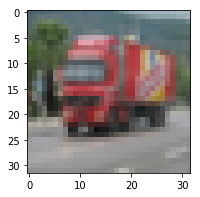

In [55]:
import matplotlib.pyplot as plt

%matplotlib inline

## The original image
idx = np.random.choice(range(len(x_test)), 1)[0]
img = x_test[idx]

fig = plt.figure(figsize=(3, 3))
plt.imshow(img)

## The extened image
img_datagen = ImageDataGenerator(rescale=1./255
                                 ,preprocessing_function = preprocessing_fun)
training_gen = img_datagen.flow_from_directory(PATH, target_size=(224,224)
                                               ,color_mode='rgb',batch_size=32, shuffle=False)

In [34]:
idx

array([9396])

## 모델 훈련

In [15]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 163us/step - loss: 1.8420 - acc: 0.3573 - val_loss: 1.7449 - val_acc: 0.3973
Epoch 2/10
50000/50000 [==============================] - 8s 161us/step - loss: 1.7331 - acc: 0.4041 - val_loss: 1.7394 - val_acc: 0.3987
Epoch 3/10
50000/50000 [==============================] - 9s 172us/step - loss: 1.7134 - acc: 0.4159 - val_loss: 1.7286 - val_acc: 0.3961
Epoch 4/10
50000/50000 [==============================] - 8s 166us/step - loss: 1.7027 - acc: 0.4210 - val_loss: 1.7178 - val_acc: 0.4063
Epoch 5/10
50000/50000 [==============================] - 8s 160us/step - loss: 1.6962 - acc: 0.4231 - val_loss: 1.7327 - val_acc: 0.4040
Epoch 6/10
50000/50000 [==============================] - 8s 159us/step - loss: 1.6893 - acc: 0.4244 - val_loss: 1.7144 - val_acc: 0.4036
Epoch 7/10
50000/50000 [==============================] - 8s 164us/step - 

In [17]:
model.layers

In [18]:
model.metrics_names

['loss', 'acc']

In [19]:
# import pickle

# weights={}
# for layer in model.layers:
#     weights[layer] = layer.get_weights()
# weights
# with open("./vgg16_weights.pkl","w") as fw:
#     pickle.dump(weights, fw)

## 모델 평가

In [20]:
model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 0s 44us/step


[1.71416015625, 0.41110000014305115]

In [31]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

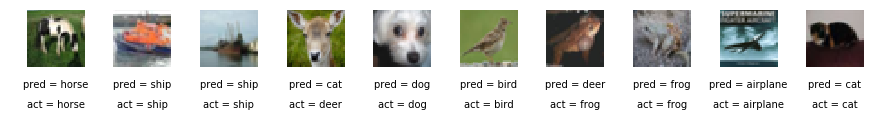

In [32]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, idx in enumerate(indices):)
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)